# INTRODUCTION

The project is designed to determine **the best location** and **business type** Goliath National Bank will lauch in Champaign by characterizing what consumer's eating habits are. The project divides this characterization process into five subquestions:

1. Users who visit one business tend to visit certain other businesses?
2. What are the most popular resturants in Champaign and where?
3. Is restaurants selection diverse or homogenuous?
4. How did the time impact the concentration and location of reviews?

Each part of sub-questions will explain how the sub-question contributes to solving our main problem and arrive at results of the sub-question. Eventually, the project summarizes our thoughts on picking the best location and business type. 


# Question 1: Do users who visit one business tend to visit certain other businesses?

This question help us to identify the connections between resturants by analyzing whether certain restuarants has high co-occurences in users'reviews. This is the first step essentially for generating the basic idea of consumer's eating habits. Stronger connections observed during this process, more likely and precisely to predict the resturants users tend to visit given a specific resturants. Those connections will confirm that there is indeed a relationship between users' food preference and resturants selection, an underlying rationale supporting the next three steps to predict and attest the most popular and most busines types as well as features of resturants selection. 


This question have two target subjects: users and users' friend. Regarding the former subject, we first draw users with according resturants which users provided reviews, then use models to find top 55 pairs of resturants that occurs together in users'review list, lastly plot the connection network to show how each resturant is connected to others. In other words, we can tell from the plot what other resturants users tend to visit after fixing a resturant point and going with the direction of the edges.

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
from collections import Counter
from itertools import combinations
import string
import pprint
import random
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
!pip install gmplot
import gmplot as gm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Part 1: Restaurants Co-occurence for Users

### Step 1: Preprocess Data

In [49]:
## Create dataframe including user-id, stars, business_name 
query1 = '''select 
            r.user_id,
            b.name
            from review as r
            left join business as b
                 on r.business_id = b.id 
            left join category as c
                 on r.business_id = c.business_id
            where b.city in ("Champaign") and c.category="Restaurants" and b.is_open = 1
            '''
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    preference = pd.read_sql(query1, con)

In [50]:
preference.sample(5)

,user_id,name
13339,w_tuktLUXxRu65tq5rRxvQ,Noodles & Company
10192,HEYqwkIjBs1ApAljmmDPlw,Nando Milano Trattoria
2616,8c3XuWaEQwzbV9AtiXB8mw,Alexander's Steakhouse
5161,epOjDB-wYAxXEX8TlM18yg,Chili's
4349,03e0cENOPYswgKw5-McrvA,Kofusion


### Step 2: Find Top Common Pairs

In [4]:
tkns = set()
cnt = Counter()

# group user_id and create name_lsit based on grouped user_id

names_df_list = preference.groupby(['user_id'])['name'].apply(list).to_dict()
names_list = list(names_df_list.values())

In [5]:
for names in names_list:
    names = sorted(names)
    
    # create a set that only contains unique names
    for name in names:
        tkns.add(name)
        
    # use combinations from the itertools library 
    # to make a list of tag pairs. 
    # We then increment the counter for each paried tag
    for paired_names in combinations(names,2):
        cnt[paired_names] += 1

In [6]:
print(f'Total number of unique resturants = {len(tkns)}')
print(f'Total number of paired resturants = {len(cnt)}')

mc = cnt.most_common(1)[0]
print(f'Most common pair = {mc[0]}, occurs {mc[1]} times.')

Total number of unique resturants = 227
Total number of paired resturants = 14433
Most common pair = ('DESTIHL Restaurant & Brew Works', 'Seven Saints'), occurs 72 times.


In [7]:
top_tkns = set()
num_top_pairs = 55

# Get most common pairs
top_pairs = cnt.most_common(num_top_pairs)

In [8]:
pair_list = []
count_list = []

for pair, count in top_pairs:
    top_tkns.add(pair[0])
    top_tkns.add(pair[1])
    pair_list.append(str(pair[0]+" -- "+str(pair[1])))
    count_list.append(count)
print(f'Total number of unique resturants = {len(top_tkns)}\n')
print('Resturants to graph:')
print(40*'-')

# Pretty print tokens
pp = pprint.PrettyPrinter(indent=2,depth=2, width=62, compact=True)
pp.pprint(top_tkns)

Total number of unique resturants = 21

Resturants to graph:
----------------------------------------
{ 'Aroma Cafe', 'Bacaro', 'Bangkok Thai and Pho 911',
  "Biaggi's Ristorante Italiano", 'Big Grove Tavern',
  'Black Dog Smoke & Ale House',
  'DESTIHL Restaurant & Brew Works', 'Dos Reales',
  "Dublin O'Neil's", 'Esquire Lounge',
  "Farren's Pub & Eatery",
  'Golden Harbor Authentic Chinese Cuisine', 'Kofusion',
  'Maize Mexican Grill', 'Original Pancake House',
  "Papa Del's Pizza", 'Pekara Bakery and Bistro',
  'Radio Maria', 'Sakanaya Restaurant', 'Seven Saints',
  "Watson's Shack & Rail"}


In [9]:
pairarray = np.asarray(pair_list).reshape(num_top_pairs,1)
countarray = np.asarray(count_list).reshape(num_top_pairs,1)
rows=np.hstack((pairarray,countarray))
pair_df = pd.DataFrame(rows, columns=['Pairs','Count'])
pair_df.style.set_properties(subset=['Pairs'], **{'width': '300px'})

### Step 3: Network Graph

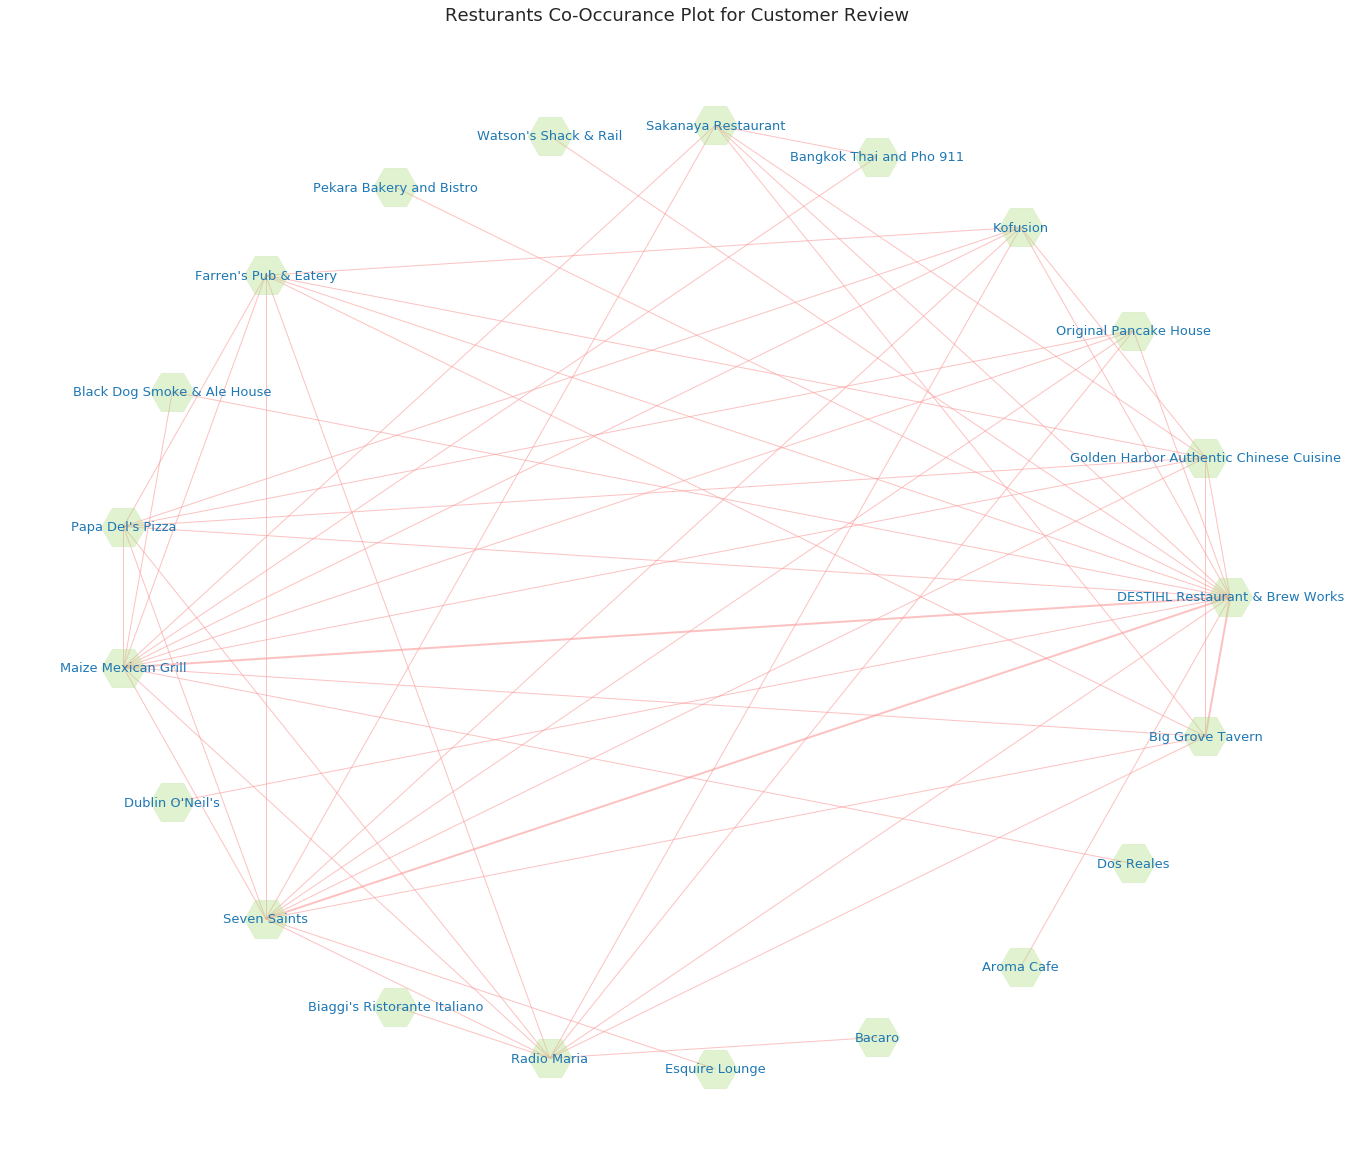

In [31]:
fig, axs = plt.subplots(figsize=(24, 21))

clrs = sns.color_palette("Paired")

sns.set(style='white', font_scale=1.5)

g = nx.Graph()

g.add_nodes_from(list(top_tkns))

for pair, count in top_pairs:
    g.add_edge(pair[0], pair[1], weight=count)
    
pos = nx.circular_layout(g)

nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_size = 2000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)
edges = []
weights = []

for n1, n2, dct in g.edges(data=True):
    edges.append((n1, n2))
    weights.append(dct['weight'])


min_weight = min(weights)
norm_weights = [int(weight/min_weight) for weight in weights]


nx.draw_networkx_edges(g, pos, edgelist=edges, 
                       width = norm_weights, 
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)


nx.draw_networkx_labels(g, pos, font_size = 13,
                        font_color = clrs[1],
                        alpha = 1.0)

axs.set_title('Resturants Co-Occurance Plot for Customer Review')
axs.set_xticklabels([])
axs.set_yticklabels([])
sns.despine(top = True, bottom = True, 
            left = True, right = True)

### Findings

From the above graph and dataframe, we identified the top 55 pairs of resturants that has the most co-occurences in  users'reviews. The following are our findings:

1. The most common pair is 'DESTIHL Restaurant & Brew Works' and 'Seven Saints' occurring 72 times. That means, two two resturants has the stronggest connection that users who visit Destihl restaurant tend to visit Seven Saints and verse versa.

2. Destihl resturants also have strong connections with Big Grove Tavern and Maize Mexican Grill, but compared to Seven Saints, users are less like to visit those two resturants. 

3. Generally speaking, the mexican grill food, nightlife or resturants have more connections than other business types. For example, Maize Mexican Grill resturant has more connections than asian food resturants such as Bangkok Thai and Sakanaya resturants. Since graph shows that users who visit many different business types will visit the mexican grill or nightlife & bar resturants, a large portion of consumers in Champiagn area presents a commonplace in eating habit that they love eating mexican grill or bar foods and tend to visit those resturants regardless of what other types of resturants they visited before and what other eating habits they have. 


# Part 2: What about their friends?

We first draw the users from reviews with resturants and their friends. Then we iterate through each user to find all his/her friend_id, and then iterate through each friend_id to locate whether this friend is one of the users. By doing this, we find all friends who are also users for every user. Next we iterate those friends to get the resturants that they provided reviews and find the top 10 pairs of resturants that occurs together. Finally, we randomly pick 3 users and plot the co-occurences graph to understand the connections among resturants.  

### Step 1: Preprocess data

In [32]:
query2 = '''select 
            r.user_id,
            b.name,
            f.friend_id
            from review as r
            left join business as b
                 on r.business_id = b.id 
            left join category as c
                 on r.business_id = c.business_id
            left join friend as f
                 on r.user_id = f.user_id
            where b.city in ("Champaign") and c.category="Restaurants" and b.is_open = 1
            '''

In [12]:
with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    friends = pd.read_sql(query2, con)

In [13]:
friends= friends.dropna()

In [14]:
friends_list =friends.groupby(['user_id'])['friend_id'].apply(list).to_dict()
users = list(friends_list.keys())

### Step 2: Find the top common pairs for friends

In [15]:
def get_top_pairs(user_id, num_pairs):
    friends_ids = friends_list[user_id]
    friends_bids=[]
    for ids in friends_ids:
        if ids in names_df_list.keys():
            friends_bids.append(names_df_list[ids])
    
    tkns = set()
    cnt = Counter()
    
    for names in friends_bids:
        names = sorted(names)
    
    # create a set that only contains unique names
        for name in names:
            tkns.add(name)
        
    # use combinations from the itertools library 
    # to make a list of tag pairs. 
    # We then increment the counter for each paried tag
        for paired_names in combinations(names,2):
            cnt[paired_names] += 1
        
    top_pairs =cnt.most_common(num_pairs)
        
    return top_pairs

In [16]:
results = []
for user in users:
    results.append(get_top_pairs(user,10))

In [17]:
results_index = []
for i in range (len(users)):
    if results[i] != []:
        if len(results[i])==10:
            results_index.append(i)

results_pairs = []
users_=[]
for i in results_index:
    results_pairs.append(results[i])
    users_.append(users[i])

In [18]:
def plot_network (user_id):
    
    top_pairs = results_pairs[users_.index(user_id)]
    
    
    top_tkns=set()
    for pair, count in top_pairs:
        top_tkns.add(pair[0])
        top_tkns.add(pair[1])
    
        
    
    fig, axs = plt.subplots(figsize=(18,12))

    clrs = sns.color_palette("Paired")

    sns.set(style='white', font_scale=1.5)

    g = nx.Graph()

    g.add_nodes_from(list(top_tkns))

    for pair, count in top_pairs:
        g.add_edge(pair[0], pair[1], weight=count)
    
    pos = nx.circular_layout(g)

    nx.draw_networkx_nodes(g, pos, with_labels=True,
                       node_size = 2000,
                       node_color=clrs[2],
                       node_shape='H',
                       alpha = 0.4)
    edges = []
    weights = []

    for n1, n2, dct in g.edges(data=True):
        edges.append((n1, n2))
        weights.append(dct['weight'])


    min_weight = min(weights)
    norm_weights = [int(weight/min_weight) for weight in weights]


    nx.draw_networkx_edges(g, pos, edgelist=edges, 
                       width = norm_weights, 
                       edge_color=clrs.as_hex()[4],
                       alpha = 0.6)


    nx.draw_networkx_labels(g, pos, font_size = 12,
                        font_color = clrs[1],
                        alpha = 1.0)

    axs.set_title('Resturants Co-Occurance Plot for Friends of Userid '+ user_id)
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    sns.despine(top = True, bottom = True, 
            left = True, right = True)

    return g

### Step 3: Examples of network graph

### Example 1

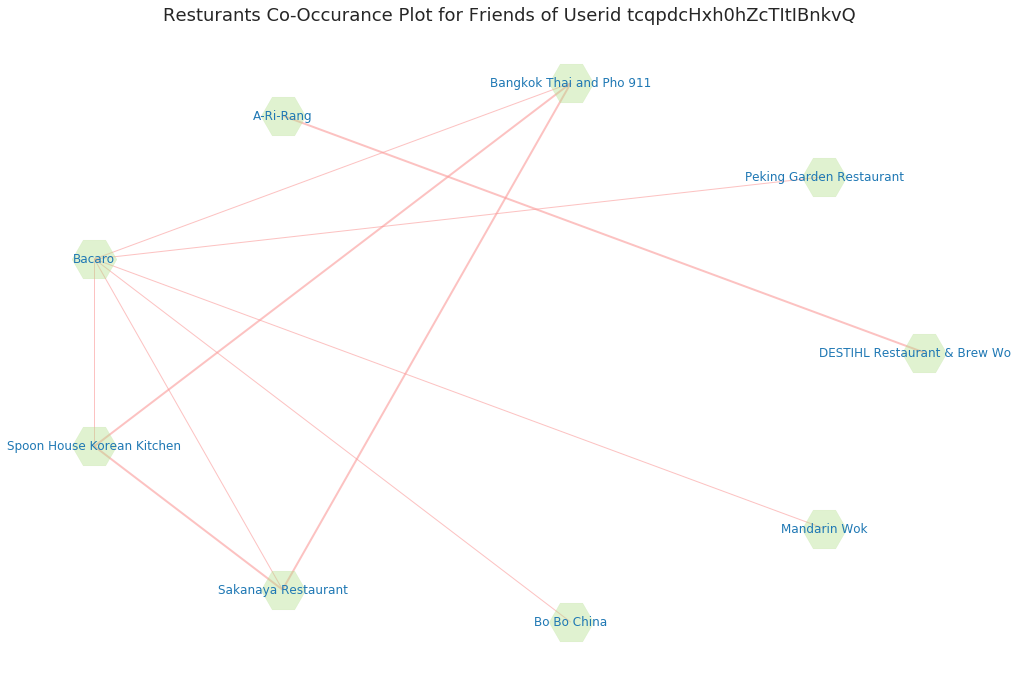

In [19]:
user_ids = random.sample(users_,3)[0]
user_id = 'tcqpdcHxh0hZcTItIBnkvQ'
plot_network(user_id)

In [20]:
print("Top 10 pairs of Friends of " + user_id)
print(40*'-')
results_pairs[users_.index(user_id)]

Top 10 pairs of Friends of tcqpdcHxh0hZcTItIBnkvQ
----------------------------------------


[(('Bangkok Thai and Pho 911', 'Sakanaya Restaurant'), 4),
 (('Bangkok Thai and Pho 911', 'Spoon House Korean Kitchen'), 4),
 (('Sakanaya Restaurant', 'Spoon House Korean Kitchen'), 4),
 (('A-Ri-Rang', 'DESTIHL Restaurant & Brew Works'), 4),
 (('Bacaro', 'Bangkok Thai and Pho 911'), 2),
 (('Bacaro', 'Bo Bo China'), 2),
 (('Bacaro', 'Mandarin Wok'), 2),
 (('Bacaro', 'Peking Garden Restaurant'), 2),
 (('Bacaro', 'Sakanaya Restaurant'), 2),
 (('Bacaro', 'Spoon House Korean Kitchen'), 2)]

### Example 2

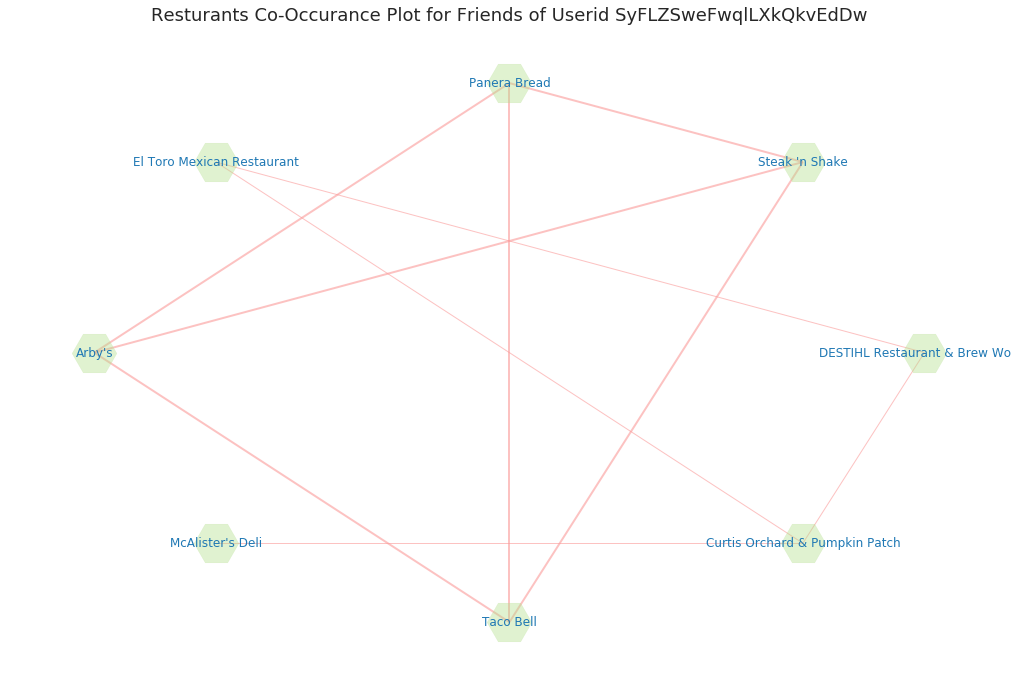

In [21]:
user_id = 'SyFLZSweFwqlLXkQkvEdDw'
plot_network(user_id)

In [22]:
print("Top 10 pairs of Friends of " + user_id)
print(40*'-')
results_pairs[users_.index(user_id)]

Top 10 pairs of Friends of SyFLZSweFwqlLXkQkvEdDw
----------------------------------------


[(("Arby's", 'Panera Bread'), 56),
 (("Arby's", "Steak 'n Shake"), 56),
 (("Arby's", 'Taco Bell'), 56),
 (('Panera Bread', "Steak 'n Shake"), 56),
 (('Panera Bread', 'Taco Bell'), 56),
 (("Steak 'n Shake", 'Taco Bell'), 56),
 (('Curtis Orchard & Pumpkin Patch', 'DESTIHL Restaurant & Brew Works'), 28),
 (('Curtis Orchard & Pumpkin Patch', 'El Toro Mexican Restaurant'), 28),
 (('Curtis Orchard & Pumpkin Patch', "McAlister's Deli"), 28),
 (('DESTIHL Restaurant & Brew Works', 'El Toro Mexican Restaurant'), 28)]

### Example 3

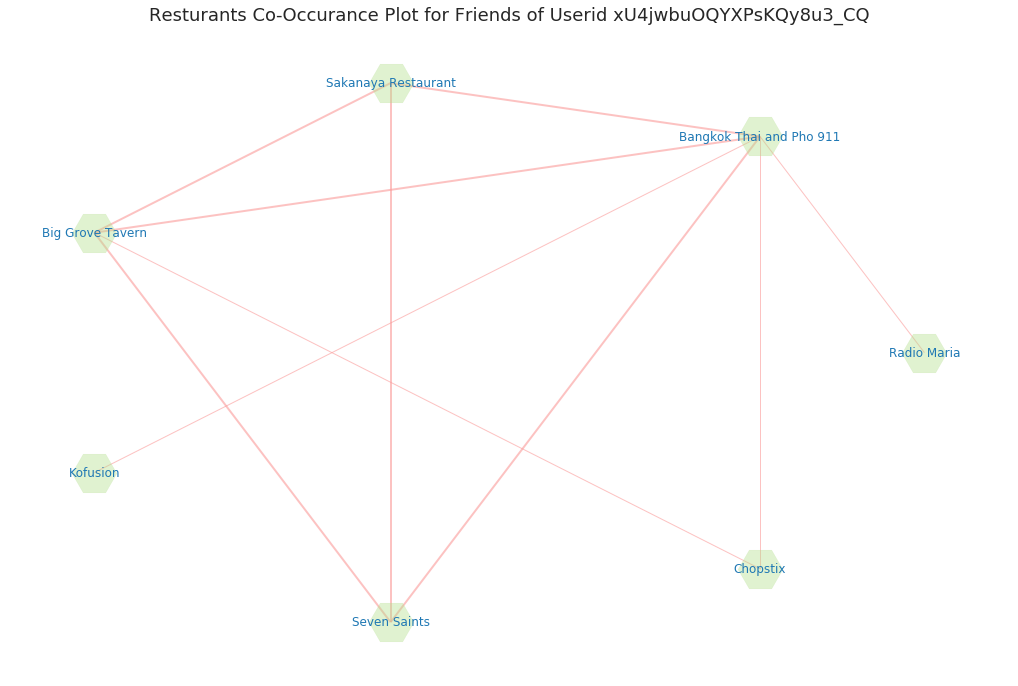

In [23]:
user_id = 'xU4jwbuOQYXPsKQy8u3_CQ'
plot_network(user_id)

In [24]:
print("Top 10 pairs of Friends of " + user_id)
print(40*'-')
results_pairs[users_.index(user_id)]

Top 10 pairs of Friends of xU4jwbuOQYXPsKQy8u3_CQ
----------------------------------------


[(('Bangkok Thai and Pho 911', 'Big Grove Tavern'), 2),
 (('Bangkok Thai and Pho 911', 'Sakanaya Restaurant'), 2),
 (('Bangkok Thai and Pho 911', 'Seven Saints'), 2),
 (('Big Grove Tavern', 'Sakanaya Restaurant'), 2),
 (('Big Grove Tavern', 'Seven Saints'), 2),
 (('Sakanaya Restaurant', 'Seven Saints'), 2),
 (('Bangkok Thai and Pho 911', 'Chopstix'), 1),
 (('Bangkok Thai and Pho 911', 'Kofusion'), 1),
 (('Bangkok Thai and Pho 911', 'Radio Maria'), 1),
 (('Big Grove Tavern', 'Chopstix'), 1)]

### Findings 

Below are our findings from three examples.
 
1. In example 1, the most common pairs are: 'Bangkok Thai and Pho 911' & 'Sakanaya Restaurant, 'Bangkok Thai and Pho 911' &'Spoon House Korean Kitchen', 'Sakanaya Restaurant' &'Spoon House Korean Kitchen','A-Ri-Rang' &'DESTIHL Restaurant & Brew Works',that occur 4 times. Part of thse four connections can be seen from the result of resturant co-occurence for users. Besides, the first three pairs show a strong connection between asian resturants, implying that users who visit one aisan resturant tend to visit other asian resturant. 

2. Example 2 has four stronggest network among Arby's, Panera Bread,Steak 'n Shake,Taco Bell, which can also be seen from the graph of resturant co-occurence for users.

3. Example 3 shows that Bangkok Thai & Pho 911 and Big Grove Tavern is the most common pair, which dosn't appear in the previous graphs. But because this pair only occur two times based on the friends review of this user, it is resonable that it is not in the graph of resturant co-occurence for users that depicts top 55 most common pairs.

4. The pair - A-Ri-Rang & DESTIHL Restaurant & Brew Works and Sakanaya Restaurant & Seven Saints - supports our previous argument that consumers visit mexican or bar & nightlife resturants have no clear preference on certain other types of business, becuase there is no certain other types of business has strong relationship with mexican or bar resturants in the view of consumer's resturant selection. From the general observations, Mexican food or bar & nightlife restaurants may be the most popular business types in Champaign area, but the next question will help us figure out the most popular business types.

In conclusion, users as well as their friends who visit one business do tend to visit other businesses. 

# Question 2: What types of restaurants are most popular and where?

# Part 1 Data Preproccessing 

## Step 1: Pull Data From the Database

First of all, we access the data from database using SQL. We chose the city of Champaign because it contains enough numbers of restaurants for us to analyze what are the features for a successful restaurant.

In [2]:
query3 = '''select b.*,
                  c.category,
                  r.*
           from business as b
           left join category as c
             on b.id = c.business_id
           left join review as r
             on b.id = r.business_id       
           where b.city in ("Champaign") 
           '''

with sql.connect('/home/data_scientist/accy571/readonly/data/yelp.db') as con:
    df = pd.read_sql(query3, con)

In [26]:
df.sample(10)

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,...,category,id,stars,date,text,useful,funny,cool,business_id,user_id
76081,TEXUVhF-G_v2Sxwqti8HQA,Old Chicago,,1910 N Neil St,Champaign,IL,61820,40.1398,-88.2438,3,...,Restaurants,PYM39nmtsluIxr9nqUxOlg,4,2011-07-01 00:00:00,"Only been there once, but it was great, far be...",0,0,0,TEXUVhF-G_v2Sxwqti8HQA,SZo8QQCKwN5sEMMpJUhBIA
90122,XOAk4yIrqsvzIm-i6t73ng,Mariya Vandivort & The AroundCU - Keller Williams,,2441 Village Green Pl,Champaign,IL,61822,40.1164,-88.2434,5,...,Real Estate Services,g_lCUt8j1_tlXK2Wc4D_jQ,5,2014-07-01 00:00:00,"We re-located to Champaign from Boston, and Ma...",0,0,0,XOAk4yIrqsvzIm-i6t73ng,Qw1y4zuX-gnCOOjX3d8U3Q
18143,ATEOnDYQCYSwCCH6hxenlQ,County Market,,2901 W Kirby Ave,Champaign,IL,61821,40.098,-88.3267,3.5,...,Shopping,_W2S8SDxzJXgahMI2hLV6Q,5,2014-12-05 00:00:00,Will never use another florist!!!\n\nWe had ou...,1,0,0,ATEOnDYQCYSwCCH6hxenlQ,p2K0K84PD4XQ01FX7OFM_g
53107,LW21U6m6axC2lCLYc0fFSA,Cream & Flutter,,114 N Walnut St,Champaign,IL,61820,40.1168,-88.2422,3.5,...,Coffee & Tea,qXsQyCIw8UBLp-FsjIbALA,4,2017-05-11 00:00:00,Been there several times now. Service is spect...,0,0,0,LW21U6m6axC2lCLYc0fFSA,2nK2qsV4fbvyzUQqWqoUHA
64158,PgMt7JtwUB-QUoRZAbwUng,Chili's,,1905 N Prospect Ave,Champaign,IL,61822,40.139,-88.2586,2.5,...,American (Traditional),4lp67SF9JTHD-OT48g3oDQ,4,2015-10-22 00:00:00,Typical chain food joint. Went with my wife a...,0,1,0,PgMt7JtwUB-QUoRZAbwUng,2ar-p9tznvhnCjoz8eL1_g
1568,-fiUXzkxRfbHY9TKWwuptw,DESTIHL Restaurant & Brew Works,,301 N Neil St,Champaign,IL,61820,40.119,-88.2443,4,...,Breakfast & Brunch,SlvrNtbmhpvo3V5AAm1bxQ,3,2017-01-07 00:00:00,My husband and I met my mom and daughter for l...,0,0,0,-fiUXzkxRfbHY9TKWwuptw,0-kN9xaij0Dr9OfKOgD7UA
95162,zrP-02glmF1Bqo9IxDhWkQ,Dick Van Dyke Appliance World,,1510 North Neil St,Champaign,IL,61820,40.1318,-88.2428,3,...,Home & Garden,YPDRmbFjOKc3wcpcJrXSVg,1,2016-08-06 00:00:00,"I had Dick Van Dyke out to fix my washer, whic...",1,0,0,zrP-02glmF1Bqo9IxDhWkQ,ekG7yjj9W8BwAN1knyzPiw
96576,ZyOgY-z9sHdHp8_FDoQAJg,Scotty's Brewhouse,,2001 S Neil St,Champaign,IL,61820,40.0923,-88.2455,3,...,Burgers,gSHmGuSA36rOKV8AtK47Og,4,2016-12-05 00:00:00,I recommend requesting ferita to be your serve...,0,0,0,ZyOgY-z9sHdHp8_FDoQAJg,6OwNCaSWiqFSk7YCwA7hNQ
27375,dn9lwYUxmhs_mLKPu7L25Q,Big Grove Tavern,,"1 E Main St, Ste 101",Champaign,IL,61820,40.1184,-88.243,3.5,...,Gastropubs,WbiHOr7QbPguCHfKtcCZJA,4,2015-06-24 00:00:00,I heard about Big Grove Tavern a year ago and ...,2,1,1,dn9lwYUxmhs_mLKPu7L25Q,dOVG-e3EY5AuwY3bq5rBpA
18335,aVOxJm-9FAeWcvB2oBxJdQ,Plant Mode,,11 E University Ave,Champaign,IL,61820,40.1162,-88.243,4.5,...,Shopping,skJfWXwSqqDOAFa2AXROJQ,5,2016-09-24 00:00:00,The owner is very knowledgeable and has a grea...,1,0,0,aVOxJm-9FAeWcvB2oBxJdQ,8_zsgKif1ZnRwVz8eKx7hA


## Step 2: Rename columns
Because there are two columns named stars, we renamed the columns to make them easier to read. The column called overall_stars contains the rating of each restaurant while the column called individual_stars has the rating given by individual customers. Below shows how we renamed the columns of the dataframe.

In [3]:
df.columns = ['id',
 'name',
 'neighborhood',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'overall_stars',
 'review_count',
 'is_open',
 'category',
 'id',
 'individual_stars',
 'date',
 'text',
 'useful',
 'funny',
 'cool',
 'business_id',
 'user_id']

## Step 3: Create a New Dataframe by Filtering Out Unnecessary Rows and Columns
Since we are only studying restaurants, we first find all restaurants by searching for values inside the category column and keep all of the restaurants in Restaurants. Then we drop the duplicates when the same restaurant name appears more than once and store the remaining unique restaurants inside Rest_name. Then we construct a name dataframe called Rest_reviews that has names of all unique restaurants. To increase the speed for processing, we also drop the some columns are not relavant for our analysis, including id, neighborhood, city, state, is_open, business_id, and user_id. The Unique_Reviews dataframe contains all restaurnats and the subcategories of restaurants. We do not include categories that named Restaurants because "Restaurant" itself does not tell us any information or specific feature of the restaurant. After we cleaned the data, this Unique_Reviews is what out future analysis is based on.  

In [46]:
#Drop rows that are not restaurants
Restaurants = df.loc[df['category'] == 'Restaurants']
Rest_name = Restaurants['name'].drop_duplicates()
#add the rows that have the names of those restaurants,so they contain 
Rest_reviews = df.loc[df['name'].isin(Rest_name.tolist())]
columns = ['id','neighborhood','city','state','is_open','business_id','user_id']
Rest_reviews = Rest_reviews.drop(columns, axis=1)
Unique_Reviews = Rest_reviews[Rest_reviews.category != 'Restaurants']
Unique_Reviews.sample(5)

,name,address,postal_code,latitude,longitude,overall_stars,review_count,category,individual_stars,date,text,useful,funny,cool
48021,Farren's Pub & Eatery,308 N Randolph St,61820,40.1184,-88.2452,4,225,Nightlife,4,2011-02-15 00:00:00,Great burgers but I go for the chicken tacos f...,0,0,0
68892,Panera Bread,616 E Green St,61820,40.1105,-88.2294,2.5,24,Salad,3,2014-11-25 00:00:00,I would give it four or five stars if it weren...,3,0,0
65717,Black Dog Smoke & Ale House,320 N Chestnut St,61820,40.118,-88.2403,4,156,Barbeque,3,2016-04-20 00:00:00,My husband and I went here while on our way tr...,0,0,0
59062,Atlanta Bread,1905 S Neil St,61820,40.0929,-88.246,3,44,Bakeries,2,2012-07-06 00:00:00,Why didn't I read my own review before going h...,2,1,0
34083,Curtis Orchard & Pumpkin Patch,3902 S Duncan Rd,61822,40.0634,-88.295,3.5,50,Food,3,2014-09-21 00:00:00,Cool place. Fun activity for the family. Face...,0,0,0


# Part 2 Find the most popular restaurant types

## Step 1: Number of Subcategories
The code below tells us that there are 131 subcategoris for restaurants. From there, we are going to the figure out what kind of subcategories have higher ratings.

In [5]:
Rest_Cat = Unique_Reviews[['category']].drop_duplicates()
a = Rest_Cat['category'].tolist()
len(a)

131

## Step 2: Find the most popular types of restaurants

When we are trying to find out the most popular type of restaurants, it is important to define popularity, which can be interpreted in two different ways. On the one hand, we can find the subcategories of restaurants that the the more numbers of occurrence. The more reviews that those subcategories have suggest that the more people have visited these kinds of restaurants. On the other hand, we can also read as the subcategories that people love the most. In the second case, we need to identify subcategories that have the highest average ratings instead of the number of occurrence. Therefore, we decided to evaluate the most popular types of restaurants using two methods.


### Method 1: Top 10 Categories that People Love the Most ( Based on the Highest Average Ratings)

First of all, we pull the category and individual_stars columns from Unique-Reviews since analysis below only requries information from these collumns. We then create an empty dictionary called d. Next, we iterate each through rows and put values inside the category column and the ratings given by each customer into the dictionary. Furthermore, we calculate the means of the individual ratings for each category and store them into a new disctionary called new_d. From the new_d dictionary, we can print the names and the ratings of the top 10 categories seperately. 

In [6]:
popular_res = Unique_Reviews[["category","individual_stars"]]
d = {}


for index, row in popular_res.iterrows():
    if row["category"] not in d.keys():
        d[row["category"]] = [int(row["individual_stars"])]
    else: 
        d[row["category"]].append(int(row["individual_stars"]))


new_d ={key:np.mean(val) for key, val in d.items()}

new_d

top_category = sorted(new_d, key=new_d.get, reverse=True)[:10]


top_avg = [new_d[elem] for elem in top_category]

print(top_category)
print(top_avg)

['Wraps', 'Florists', 'Gift Shops', 'Flowers & Gifts', 'Kosher', 'Food Stands', 'Meat Shops', 'Caribbean', 'Health Markets', 'Whiskey Bars']
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.8604651162790695, 4.8196721311475406, 4.75, 4.75]


From the results, we can conclude that the most popular restaurant categories are Wraps, Florists, Gift Shops, Flowers & Gifts, Kosher, Food Stands, Meat Shops, Caribbean, Health Markets, and Whiskey Bars. Even though some of them, such as the Florists and Gift Shops may not seem to be direcly related with the characterics of a restaurant. But since they are on the list of top ten most popular restuarant categories, it, to some degree, suggests that restaurants with these features are generally liked by the customers. 

The graphs below show the distribution of the averge ratings of all of the categories and that of the top 10 categories with the highest average ratings. In the previous section, we have store the categories their means of individual ratings into new_d and used it again to calculate the average ratings for all categories. As you can see from the first histogram, most of the categories are rated between 3 stars to 4 stars. So generally speaking, if the rating it above 4, it means that people tend to like it more. The second histogram shows the top 10 averaging ratings. There are six categories that have the full 5 stars ratings. and they are Wraps, Florists, Gift Shops, Flowers & Gifts, and Kosher and Food Stands. The ratings of other four categories range from 4.75 to 4.85, which are still way beyond the bar.

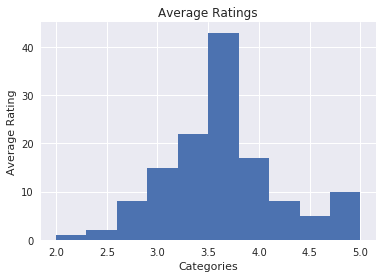

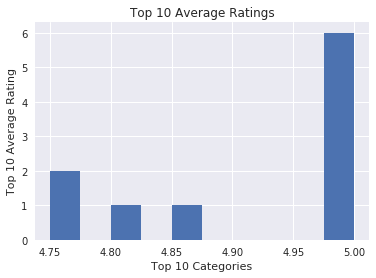

In [7]:
# fixed bin size
#bins = np.arange(0,5,1) # fixed bin size
Category = sorted(new_d, key=new_d.get, reverse=True)


avg = [new_d[elem] for elem in Category]

plt.hist(avg)
plt.title('Average Ratings')
plt.xlabel('Categories')
plt.ylabel('Average Rating')

plt.show()

plt.hist(top_avg)
plt.title('Top 10 Average Ratings')
plt.xlabel('Top 10 Categories')
plt.ylabel('Top 10 Average Rating')

plt.show()

### Method 2: Top 10 Categories that People Visit the Most (Based on the Number of Occurrence) 

To find the categories that appear the most, we went back to the Unique_Reviews dataframe before we dropped out the duplicated categories.  We converted the category into a list and used Counter to counter the occurrence of different categories of restaurants and sorted the data. As you can see, the top 10 categories that people visit the most are Nightlife, Bars, Food, Mexican, American (New), American (Traditional), Breakfast & Brunch, Pizza, Chiese, and Sandwiches. 

In [8]:
cat = Unique_Reviews['category'].tolist()

d = {}

mostcategory = Counter(cat)
for i in sorted(mostcategory, key=mostcategory.get, reverse=True):
    #print (i, mostcategory[i])
    d[i] = mostcategory[i]


top10 = {elem:d[elem] for elem in list(d.keys())[:10]}
bottom10 = {elem:d[elem] for elem in list(d.keys())[-10:]}

print(top10)
print(bottom10)

{'Nightlife': 3458, 'Bars': 3368, 'Food': 2689, 'Mexican': 2059, 'American (New)': 2010, 'American (Traditional)': 1980, 'Breakfast & Brunch': 1925, 'Pizza': 1870, 'Chinese': 1497, 'Sandwiches': 1490}
{'Internet Cafes': 7, 'Pasta Shops': 6, 'Wraps': 6, 'Kosher': 5, 'Dim Sum': 5, 'Whiskey Bars': 4, 'Food Stands': 4, 'Florists': 3, 'Gift Shops': 3, 'Flowers & Gifts': 3}


We also created a word cloud graph that shows the top 30 categories. The more reviews, the more times that the category appears. 

In [9]:
top30 = {elem:d[elem] for elem in list(d.keys())[:30]}
string_cat = ','.join(top30.keys())
string_cat

'Nightlife,Bars,Food,Mexican,American (New),American (Traditional),Breakfast & Brunch,Pizza,Chinese,Sandwiches,Salad,Sushi Bars,Burgers,Italian,Japanese,Asian Fusion,Pubs,Lounges,Fast Food,Thai,Gluten-Free,Korean,Barbeque,Delis,Event Planning & Services,Steakhouses,Breweries,Indian,Mediterranean,Caterers'

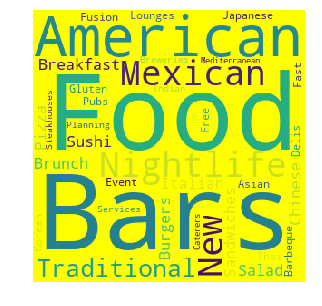

In [10]:
#Convert all the required text into a single string here 
#and store them in word_string

#you can specify fonts, stopwords, background color and other options

wordcloud = WordCloud(    background_color='Yellow',
                          width=300,
                          height=300
                         ).generate(string_cat)
plt.figure(figsize =(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Step 3: Evaluate the Results of the Most Popular Restaurant Types by Using the Two Measures

The categories on the Top 10 Categories that People Love the Most and the Top 10 Categories that People Visit the Most are completely different, which makes us wonder which one can more accurately reflect the popularity of the categories. The first method, which is based on the ratings, tells us on averge which category has the highest ratings. Even though there are several categories that are rated as 5, we realized that it was partial because these categories do not have too many reviews. The numbers of reviews for Wraps, Kosher, Food stands, Florists, Gift Shops and  Flower & Gifts are all below 6.  When the number of the reviews is small, it is likely that the ratings are biased. In constrast, the result from the second method is more reliable. Even though the ratings of the categories on the second list may not be as high as those on the other list, the great number of people going to those places has already partly shown that those categories are meeting the demanded of the public. Therefore, we should rely on the second method to determine the most popular types of restaurants.


# Part 3: Most popular location

## Step 1 Restaurant Locations

In the original dataframe, the data 'latitude' and 'longitude' column are not floats. Therefore, we convert these two columns into floats, and then build two lists of latitudes and longitudes of all the restaurants. To build a scatter plot of locations of all the restaraunts, we create a data frame 'Map' with the location data. 

 

In [11]:
Unique_Reviews['latitude'] = Unique_Reviews['latitude'].convert_objects(convert_numeric=True)
Unique_Reviews['longitude'] = Unique_Reviews['longitude'].convert_objects(convert_numeric=True)

lat = Unique_Reviews['latitude'].tolist()
long = Unique_Reviews['longitude'].tolist()

Mapdata = {'longitude':long,'latitude':lat}
Map=pd.DataFrame(data=Mapdata)

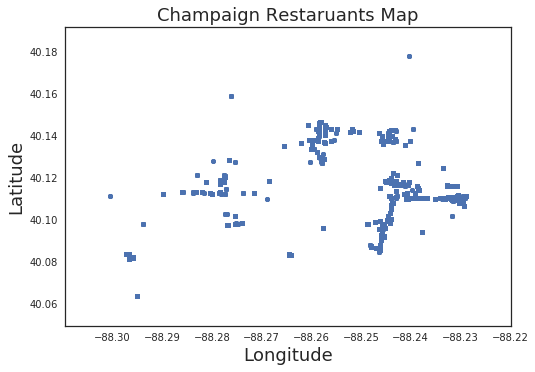

In [47]:
ax=Map.plot.scatter(x='longitude',y='latitude')
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_title('Champaign Restaruants Map', fontsize=18)
#sns.despine(offset = 5, trim=True)
sns.set(style="white")
plt.show()

The scatter plot above, 'Champaign Restaurants Map', is build with the map location dataframe 'Map'. With latitudes on the y-axis and longitudes on the x-axis, the scatter plot is a simulation of an actual map. We can see that the scatter plot is centered around **(-88.26, 40.12)**. There are also four patterned clusters showing areas that are concentrated with many restaurants. One of the clusters centered around (-88.26, 40.14) is more like a circle. The other three, two of them lined along the latitude of 40.11 and another one lined along -88.245, appear to be streets. 

Though the scatter plot is already providing us information to a certain extent, to better inform our investor, we put the scatter plot on top of google map. At first, we centered the google map around (-88.26, 40.12) as indicated by the previous scatter plot. However, with a few outliers in the north, the google map doesn't present a very useful image. To fix that, we decide to dump the outliers in the north and shift the center of the map to (-88.26, 40.10).

In [13]:
champaign = gm.GoogleMapPlotter(40.10, -88.26, 13)
champaign.scatter(lat, long, '#3B0B39', size=40, marker=False)

champaign.draw("scattermap.html")

In [14]:
%%HTML
<iframe width ="500" height = "500", src = "scattermap.html"></iframe>

From the google map, we can clearly see that, the circle-shaped cluster in the scatter plot is **downtown Champaign, the area between Hill Street and University Avenue on Neil Street**. The three streets clustered with restaurants are **E Green Street between 4th Street and Wright Street, Neil Street, and Springfield Avenue**. 

## Step 2 Popularity of Locations
However, clustering restaurants doesn't necessarilly mean its popularity. To have a better view of the popularity, we build a heatmap off of the google map. Since it is build based on the location data of all reviews, this heatmap will show where are the places customers tend to visit more or leave reviews more. 

In [15]:
champaign = gm.GoogleMapPlotter(40.10, -88.26, 13)
champaign.heatmap(lat, long, radius=20)
champaign.draw("heatmap.html")

In [16]:
%%HTML
<iframe width ="100%" height = "500", src = "heatmap.html"></iframe>

From the heatmap, we can easily find out that **E Green Street and downtown Champaign** are the most popularly reviewed area. While there are many restaurants on Neil Street and Springfield Avenue, these restaurants are much less popular comparing to E Green Street and downtown Champaign. 

## Step 3 Pattern of the Top 5 Categories

From part 2 step 2 method 2 above, we can see that the 5 most popularly reviewed categories are 'Nightlife', 'Bars', 'Food', 'Mexican', 'American (New)'. To look at the locations from a restaurant category perspective, we filter the data for these five categories and assign colors to each of them. 'Red' is the color for 'Nightlife', 'Orange' is the color for 'Bars', 'Green' is the color for 'Food', 'Blue' is the color for 'Mexican', and 'Yellow' is the color for 'American (New)'. Then, we build a scatter plot 'Top Five Reviewed Champaign Categories' simulating a map. 




In [17]:
Nightlife_Reviews=Unique_Reviews[Unique_Reviews.category == 'Nightlife']
Bars_Reviews=Unique_Reviews[Unique_Reviews.category == 'Bars']
Food_Reviews=Unique_Reviews[Unique_Reviews.category == 'Food']
Mexican_Reviews=Unique_Reviews[Unique_Reviews.category == 'Mexican']
AmericanNew_Reviews=Unique_Reviews[Unique_Reviews.category == 'American (New)']

In [18]:
Nightlifelat = Nightlife_Reviews['latitude'].tolist()
Nightlifelong = Nightlife_Reviews['longitude'].tolist()
Nightlife_c=['red']*len(Nightlifelong)

Barslat = Bars_Reviews['latitude'].tolist()
Barslong = Bars_Reviews['longitude'].tolist()
Bars_c=['orange']*len(Barslong)

Foodlat = Food_Reviews['latitude'].tolist()
Foodlong = Food_Reviews['longitude'].tolist()
Food_c=['green']*len(Foodlong)

Mexilat = Mexican_Reviews['latitude'].tolist()
Mexilong = Mexican_Reviews['longitude'].tolist()
Mexi_c=['blue']*len(Mexilong)

AmeriNlat = AmericanNew_Reviews['latitude'].tolist()
AmeriNlong = AmericanNew_Reviews['longitude'].tolist()
AmeriN_c=['yellow']*len(AmeriNlong)

colors=Nightlife_c+Bars_c+Food_c+Mexi_c+AmeriN_c
Topfivelats=Nightlifelat+Barslat+Foodlat+Mexilat+AmeriNlat
Topfivelongs=Nightlifelong+Barslong+Foodlong+Mexilong+AmeriNlong

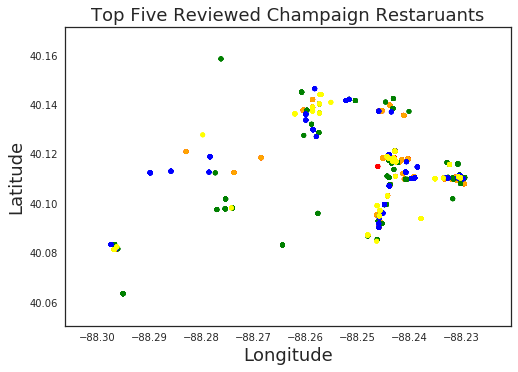

In [19]:
Topfivemapdata = {'longitude':Topfivelongs,'latitude':Topfivelats}
TopfiveMap=pd.DataFrame(data=Topfivemapdata)

ax=TopfiveMap.plot.scatter(x='longitude',y='latitude', c=colors,legend=True)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_title('Top Five Reviewed Champaign Restaruants', fontsize=18)
#sns.despine(offset = 5, trim=True)
sns.set(style="white")
plt.show()

These restaurants are still clustered around downtown Champaign and East Green Street, however we are not able to see a clear pattern of these five categories.

# Part 4: Machine Learning
After we find the types and locations of the most popular restaurants, we hope to build a decision tree classification model to predict the relationships between the ratings and restaurants' features, including their categories, longitudes and altitudes.

## Step 1: Data Preprocessing
- Normalized the longitude and altitude attributes to improve the accuracy
- Converted categorical strings into numerical features

In [20]:
d ={}  # name:[star]
for index, row in Rest_reviews.iterrows():
    if row['category'] in d.keys():
        d[row['category']] += 1
    else:
        d[row['category']] = 1
    
d = {k : v for k,v in d.items()}

#cat.inverse_transform([119])

min_max_scaler = preprocessing.MinMaxScaler()
a = Unique_Reviews[['latitude','longitude']] #returns a numpy array
n_scaled = min_max_scaler.fit_transform(a)
df_normalized = pd.DataFrame(n_scaled)

In [21]:
Unique_Reviews['new latitude'] = np.array(df_normalized.loc[:,0])
Unique_Reviews['new longitude'] = np.array(df_normalized.loc[:,1])
Unique_Reviews

dtree_rest = Unique_Reviews.loc[:,['new latitude','new longitude','category','useful','funny','cool','individual_stars']]
cat = LabelEncoder()
dtree_rest["category"] = cat.fit_transform(dtree_rest["category"])

## Step 2: Construct the Model

In [22]:
features = dtree_rest[['new latitude','new longitude','category']]
labels = dtree_rest[['individual_stars']]


frac = 0.3
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

res_model = DecisionTreeClassifier(random_state=23)

res_model = res_model.fit(d_train, l_train)



# Classify test data and display score and report
predicted = res_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))


predicted = [int(elem) for elem in predicted]
l_test = pd.Series(l_test['individual_stars']).tolist()
l_test = [int(elem) for elem in l_test]
labels = [1,2,3,4,5]

Decision Tree Classification Score = 36.0%

Classification Report:
              precision    recall  f1-score   support

          1       0.35      0.29      0.32      1854
          2       0.19      0.07      0.10      1840
          3       0.22      0.11      0.15      2465
          4       0.32      0.44      0.37      4142
          5       0.45      0.56      0.50      4780

avg / total       0.33      0.36      0.33     15081




## Step 3: Evaluation

Based on the decision tree classification, the accuracy of the prediction is 36%. Considering the limited number of restaurant attributes we have, the accuracy is reasonable. Since we have 5 levels of ratings from 1 star to 5 stars, the probability of taking a random guess and predict the correct rating is 20%. Because of the decision tree model, we succesfully increased the prediction accuracy by 16%. 

# Question 3: Is the restaurant selection diverse or homogenous?

#### In this part, we hope to answer the following questions.

- Are there a lot of a few types of restaurants? 
- Has this been changing over time?
- Is there a demand for more types of food?

# Part 1 Data Preproccessing
## Step 1: Data Selection

In [23]:
sel_rest=Unique_Reviews[['name', 'category', 'date']]

## Step 2: Find Start and End Date

In [24]:
# Convert 'date' type from object to datetime
sel_rest['date']=pd.to_datetime(sel_rest.date)
# To find out the earliest and lastest date of selected data
print(sel_rest.date.min())
print(sel_rest.date.max())

2004-10-12 00:00:00
2017-07-26 00:00:00


## Step 3: Sort Data by Year

Although we know all types of business that are related to restaurants, we need to separate data by different year, so that we can see the trend of the numbers of types and the number of businesses year by year. 

In [25]:
sel_rest['year']=sel_rest.date.dt.year

In [26]:
#mask = (sel_rest['date'] > '2004-1-1') & (sel_rest['date'] <= '2004-12-31')
#print(sel_rest.loc[mask])
rest_2004 = sel_rest[(sel_rest['date'] > '2004-1-1') & (sel_rest['date'] <= '2004-12-31')]
rest_2005 = sel_rest[(sel_rest['date'] > '2005-1-1') & (sel_rest['date'] <= '2005-12-31')]
rest_2006 = sel_rest[(sel_rest['date'] > '2006-1-1') & (sel_rest['date'] <= '2006-12-31')]
rest_2007 = sel_rest[(sel_rest['date'] > '2007-1-1') & (sel_rest['date'] <= '2007-12-31')]
rest_2008 = sel_rest[(sel_rest['date'] > '2008-1-1') & (sel_rest['date'] <= '2008-12-31')]
rest_2009 = sel_rest[(sel_rest['date'] > '2009-1-1') & (sel_rest['date'] <= '2009-12-31')]
rest_2010 = sel_rest[(sel_rest['date'] > '2010-1-1') & (sel_rest['date'] <= '2010-12-31')]
rest_2011 = sel_rest[(sel_rest['date'] > '2011-1-1') & (sel_rest['date'] <= '2011-12-31')]
rest_2012 = sel_rest[(sel_rest['date'] > '2012-1-1') & (sel_rest['date'] <= '2012-12-31')]
rest_2013 = sel_rest[(sel_rest['date'] > '2013-1-1') & (sel_rest['date'] <= '2013-12-31')]
rest_2014 = sel_rest[(sel_rest['date'] > '2014-1-1') & (sel_rest['date'] <= '2014-12-31')]
rest_2015 = sel_rest[(sel_rest['date'] > '2015-1-1') & (sel_rest['date'] <= '2015-12-31')]
rest_2016 = sel_rest[(sel_rest['date'] > '2016-1-1') & (sel_rest['date'] <= '2016-12-31')]
rest_2017 = sel_rest[(sel_rest['date'] > '2017-1-1') & (sel_rest['date'] <= '2017-12-31')]

In [27]:
print('2004')
print(len(rest_2004.name.unique()), 'stores')
print(len(rest_2004.category.unique()), 'cateogries')
print('\n')
print('2005')
print(len(rest_2005.name.unique()), 'stores')
print(len(rest_2005.category.unique()), 'cateogries')
print('\n')
print('2006')
print(len(rest_2006.name.unique()), 'stores')
print(len(rest_2006.category.unique()), 'cateogries')
print('\n')
print('2007')
print(len(rest_2007.name.unique()), 'stores')
print(len(rest_2007.category.unique()), 'cateogries')
print('\n')
print('2008')
print(len(rest_2008.name.unique()), 'stores')
print(len(rest_2008.category.unique()), 'cateogries')
print('\n')
print('2009')
print(len(rest_2009.name.unique()), 'stores')
print(len(rest_2009.category.unique()), 'cateogries')
print('\n')
print('2010')
print(len(rest_2010.name.unique()), 'stores')
print(len(rest_2010.category.unique()), 'cateogries')
print('\n')
print('2011')
print(len(rest_2011.name.unique()), 'stores')
print(len(rest_2011.category.unique()), 'cateogries')
print('\n')
print('2012')
print(len(rest_2012.name.unique()), 'stores')
print(len(rest_2012.category.unique()), 'cateogries')
print('\n')
print('2013')
print(len(rest_2013.name.unique()), 'stores')
print(len(rest_2013.category.unique()), 'cateogries')
print('\n')
print('2014')
print(len(rest_2014.name.unique()), 'stores')
print(len(rest_2014.category.unique()), 'cateogries')
print('\n')
print('2015')
print(len(rest_2015.name.unique()), 'stores')
print(len(rest_2015.category.unique()), 'cateogries')
print('\n')
print('2016')
print(len(rest_2016.name.unique()), 'stores')
print(len(rest_2016.category.unique()), 'cateogries')
print('\n')
print('2017')
print(len(rest_2017.name.unique()), 'stores')
print(len(rest_2017.category.unique()), 'cateogries')
print('\n')

2004
5 stores
9 cateogries


2005
19 stores
35 cateogries


2006
39 stores
58 cateogries


2007
117 stores
85 cateogries


2008
124 stores
89 cateogries


2009
130 stores
90 cateogries


2010
177 stores
96 cateogries


2011
187 stores
104 cateogries


2012
193 stores
106 cateogries


2013
208 stores
103 cateogries


2014
212 stores
112 cateogries


2015
223 stores
115 cateogries


2016
224 stores
117 cateogries


2017
218 stores
113 cateogries




# Part 2: Visualization

## Step 1: Plot the trends
As we can see in the plots below, from 2004 to 2017, the general trends for the total numbers of business type and for the total number of restaurants are increasing. Yet, we may notice that there are small decreases in year 2017. It is becasue the selected data only covers till July 2017. If we had data covered the whole year 2017, we would have an noticeable incease in 2017.

In [28]:
year_sum=[('year', ['2004','2005','2006','2007','2008','2009','2010','2011', \
                    '2012', '2013', '2014', '2015', '2016','2017']),
          ('num_categories',[9,35,58,85,89,90,96,104,106,103,112,115,117,113]), \
          ('num_restaurants', [5,19,39,117,124,130,177,187,193,208,212,223,224,218])]
df1 = pd.DataFrame.from_items(year_sum)

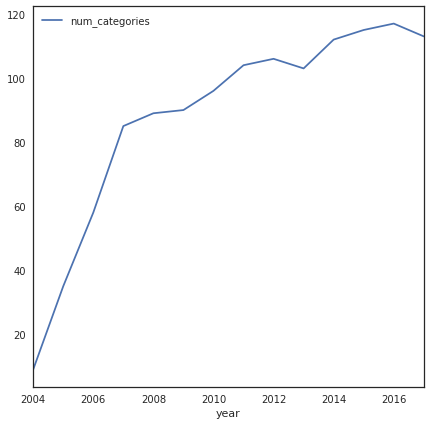

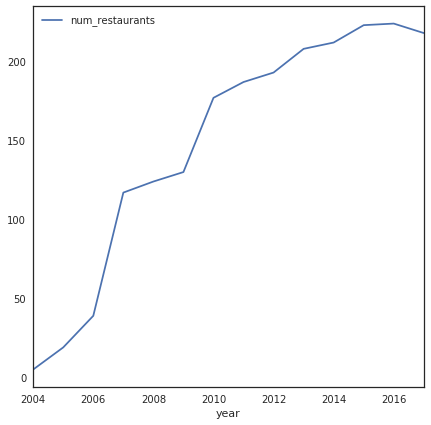

In [29]:
df1.plot(x='year', y='num_categories', figsize=(7,7))
df1.plot(x='year', y='num_restaurants', figsize=(7,7))

## Step 2: Find the top 10 popular types of business
We group the selected data according to column 'category', and find the total number of reviews that each category has. Assuming that the more reviews a category has, the more popular this type of buisness is, we find the top 10 types of businesses that have the highest 10 numbers of reviews. As result, we find that in sequences, nightlife, bars, food, mexican, American (new), American (traditional), breakfast & brunch, pizza, Chinese, and sandwishes are the 10 most popular types of business.

In [30]:
top_cat=sel_rest.groupby('category').size().nlargest(10)
top_cat

category
Nightlife                 3458
Bars                      3368
Food                      2689
Mexican                   2059
American (New)            2010
American (Traditional)    1980
Breakfast & Brunch        1925
Pizza                     1870
Chinese                   1497
Sandwiches                1490
dtype: int64

### 1. Select only top 10 category data

In [31]:
top_10=sel_rest[sel_rest.category.isin(['Nightlife','Bars','Food','Mexican', 'American (New)', \
        'American (Traditional)', 'Breakfast & Brunch', 'Pizza', 'Chinese', 'Sandwiches'])]

### 2. Find each category's annual review counts

In [32]:
print('Nightlife', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Nightlife') & (top_10['year'] == 2017)]), '\n')
print('Bars', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Bars') & (top_10['year'] == 2017)]), '\n')
print('Food', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Food') & (top_10['year'] == 2017)]), '\n')
print('Mexican', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Mexican') & (top_10['year'] == 2017)]), '\n')
print('American (New)', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'American (New)') & (top_10['year'] == 2017)]), '\n')
print('American (Traditional)', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'American (Traditional)') & (top_10['year'] == 2017)]), '\n')
print('Breakfast & Brunch', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Breakfast & Brunch') & (top_10['year'] == 2017)]), '\n')
print('Pizza', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Pizza') & (top_10['year'] == 2017)]), '\n')
print('Chinese', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Chinese') & (top_10['year'] == 2017)]), '\n')
print('Sandwiches', '\n'
      '2004: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2004)]), '\n'
      '2005: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2005)]), '\n'
      '2006: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2006)]), '\n'
      '2007: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2007)]), '\n'
      '2008: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2008)]), '\n'
      '2009: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2009)]), '\n'
      '2010: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2010)]), '\n'
      '2011: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2011)]), '\n'
      '2012: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2012)]), '\n'
      '2013: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2013)]), '\n'
      '2014: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2014)]), '\n'
      '2015: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2015)]), '\n'
      '2016: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2016)]), '\n'
      '2017: ',len(top_10.loc[(top_10['category'] == 'Sandwiches') & (top_10['year'] == 2017)]), '\n')

Nightlife 
2004:  0 
2005:  7 
2006:  12 
2007:  74 
2008:  82 
2009:  113 
2010:  147 
2011:  210 
2012:  230 
2013:  293 
2014:  411 
2015:  625 
2016:  743 
2017:  511 

Bars 
2004:  0 
2005:  7 
2006:  12 
2007:  74 
2008:  79 
2009:  109 
2010:  146 
2011:  197 
2012:  220 
2013:  287 
2014:  398 
2015:  606 
2016:  729 
2017:  504 

Food 
2004:  1 
2005:  3 
2006:  8 
2007:  56 
2008:  55 
2009:  91 
2010:  130 
2011:  176 
2012:  185 
2013:  192 
2014:  310 
2015:  522 
2016:  581 
2017:  379 

Mexican 
2004:  1 
2005:  5 
2006:  5 
2007:  40 
2008:  53 
2009:  76 
2010:  136 
2011:  197 
2012:  181 
2013:  211 
2014:  264 
2015:  350 
2016:  364 
2017:  176 

American (New) 
2004:  0 
2005:  2 
2006:  6 
2007:  29 
2008:  18 
2009:  46 
2010:  79 
2011:  132 
2012:  171 
2013:  213 
2014:  303 
2015:  405 
2016:  365 
2017:  241 

American (Traditional) 
2004:  1 
2005:  4 
2006:  3 
2007:  55 
2008:  69 
2009:  65 
2010:  92 
2011:  121 
2012:  143 
2013:  144 
2014:  218 
201

In [33]:
top_year=[('year', ['2004','2005','2006','2007','2008','2009','2010','2011', \
                    '2012', '2013', '2014', '2015', '2016','2017']),
          ('Nightlife',[0, 7, 12, 74, 82, 113, 147, 210, 230, 293, 411, 625, 743, 511]), \
          ('Bars', [0, 7, 12, 74, 79, 109, 146, 197, 220, 287, 398, 606, 729, 504]), \
          ('Food',[1, 3, 8, 56, 55, 91, 130, 176, 185, 192, 310, 522, 581, 379]), \
          ('Mexican',[1, 5, 5, 40, 53, 76, 136, 197, 181, 211, 264, 350, 364, 176]), \
          ('American (New)',[0, 2, 6, 29, 18, 46, 79, 132, 171, 213, 303, 405, 365, 241]), \
          ('American (Traditional)',[1, 4, 3, 55, 69, 65, 92, 121, 143, 144, 218, 310, 447, 308]), \
          ('Breakfast & Brunch',[0, 4, 2, 28, 38, 50, 70, 125, 167, 205, 267, 386, 354, 229]), \
          ('Pizza',[4, 7, 11, 50, 70, 100, 114, 149, 156, 151, 203, 335, 337, 183]), \
          ('Chinese',[0, 1, 5, 25, 29, 44, 111, 146, 132, 169, 191, 228, 228, 188]), \
          ('Sandwiches',[3, 2, 5, 54, 49, 82, 99, 132, 126, 131, 169, 232, 265, 141])]
df2 = pd.DataFrame.from_items(top_year)

In [34]:
df2

,year,Nightlife,Bars,Food,Mexican,American (New),American (Traditional),Breakfast & Brunch,Pizza,Chinese,Sandwiches
0,2004,0,0,1,1,0,1,0,4,0,3
1,2005,7,7,3,5,2,4,4,7,1,2
2,2006,12,12,8,5,6,3,2,11,5,5
3,2007,74,74,56,40,29,55,28,50,25,54
4,2008,82,79,55,53,18,69,38,70,29,49
5,2009,113,109,91,76,46,65,50,100,44,82
6,2010,147,146,130,136,79,92,70,114,111,99
7,2011,210,197,176,197,132,121,125,149,146,132
8,2012,230,220,185,181,171,143,167,156,132,126
9,2013,293,287,192,211,213,144,205,151,169,131


## Step3: Plot the numbers of reviews for each category
From the plot below, we can see that all these 10 10 types of business are increasingly popular in Champaign from year 2004 to year 2017. Specifically, Nightlife, Bars, and American (Traditional) increase significantly in the past few years. Another thing is that the big increase in all 10 categories in year 2017 is because the selected data only covers till July 2017. If we had data that covers till the end of year 2017, we should have a noticeble increase in most categories.

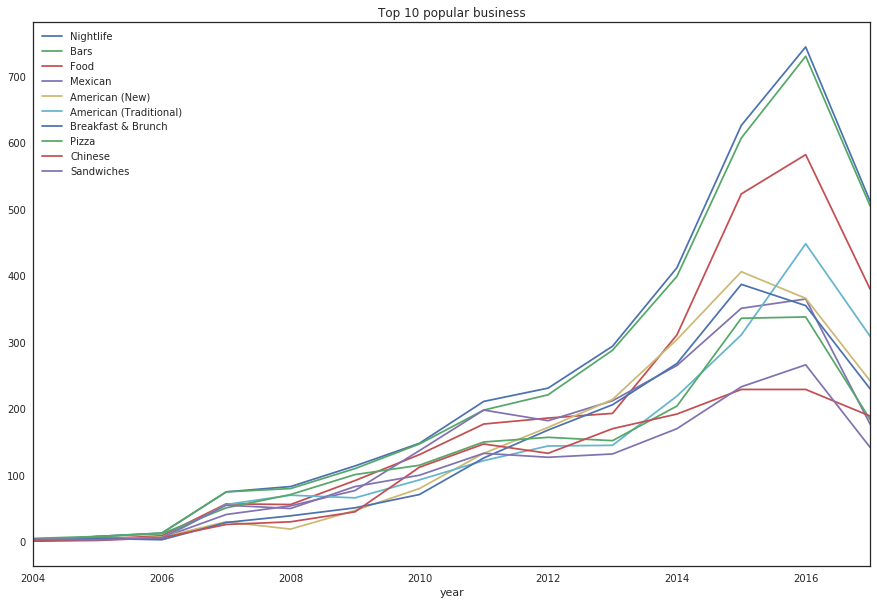

In [35]:
df2.plot(figsize=(15,10), title='Top 10 popular business', x=df1['year'])

# Part 3 Conclusion
From the above plots, we conclude that more numbers and more types of restaurants are opening in Champaign. And based on the number of reviews, we find that nightlife, bars, food, mexican, American (new), American (traditional), breakfast & brunch, pizza, Chinese, and sandwishes are the 10 most popular types of business. On top of that, these 10 types of business are increasingly popular from year 2004 to year 2017. In particular, Nightlife, Bars, and American (Traditional) increase significantly in the past few years. Another thing is that the big increase in all 10 categories in year 2017 is because the selected data only covers till July 2017. If we had data that covers till the end of year 2017, we should have a noticeble increase in most categories. 

In conclusion, it is good idea to invest Nightlife, Bars, and American (Traditional) business in Champaign.

# Question 4: How did the time impact the concentration and location of reviews?

# Part 1 Data Preprocessing

We follow the same Steps 1-3 of Question 2, Part 1, as we will once again analyze the same information. Where in Question 4 we analyzed the popularity of restaurant types over time, in Question 5 we will try and see if the popularity shifted from locations over time.

## Step 1: Pull Data From the Database

We will use the same information, reviews in the Champaign area, as usual.

## Step 2: Ajust Index for Time
As our index is currently just a long list of numbers, and our analysis will look at changes over time, it will be easier to sort through the data by having the year, month, and day as our index instead.

Below is the code for this step, and how our Pandas DataFrame looks after the change.

In [36]:
Unique_Reviews.index = pd.DatetimeIndex(Unique_Reviews.date)
Unique_Reviews.sample(5)

,name,address,postal_code,latitude,longitude,overall_stars,review_count,category,individual_stars,date,text,useful,funny,cool,new latitude,new longitude
date,,,,,,,,,,,,,,,,
2017-06-09,Esquire Lounge,106 N Walnut St,61820,40.1166,-88.2423,4,104,Food,4,2017-06-09 00:00:00,Esquire is the perfect place to stop for an af...,0,0,0,0.465035,0.812849
2013-10-15,Penn Station,605 S 6th St,61820,40.1108,-88.2306,3,15,Sandwiches,2,2013-10-15 00:00:00,What's up with the grease-soaked sandwiches he...,0,0,0,0.414336,0.976257
2014-09-20,DESTIHL Restaurant & Brew Works,301 N Neil St,61820,40.1190,-88.2443,4,449,Gluten-Free,4,2014-09-20 00:00:00,I like their beers and you can get samplers. T...,0,0,0,0.486014,0.784916
2017-05-17,Jupiter's Pizzeria and Billards,2511 Village Green Pl,61822,40.0815,-88.2963,3,74,Arcades,3,2017-05-17 00:00:00,Half price pizza on Tuesday night is a great d...,0,0,0,0.158217,0.058659
2011-05-17,Esquire Lounge,106 N Walnut St,61820,40.1166,-88.2423,4,104,Food,1,2011-05-17 00:00:00,I really don't understand how this place can b...,3,0,1,0.465035,0.812849


To be able to use the 'latitude' and 'longitude' column contents in hexbins plots, we need to convert their contents, which are currently strings, into floats. The code below changes the columns' content types, but it doesn't look any different in the Pandas DataFrame. "40.1398" will still be "40.1398".

In [37]:
Unique_Reviews['latitude'] = Unique_Reviews['latitude'].convert_objects(convert_numeric=True)
Unique_Reviews['longitude'] = Unique_Reviews['longitude'].convert_objects(convert_numeric=True)

Now our code is all set up for use in hexbins plots!

# Part 2 Champaign as a Whole

Before we take a look the most popular categories and how time affected where they were most popular, let's take a quick look at where the reviews are most concentrated over the entire span of time that the database has.

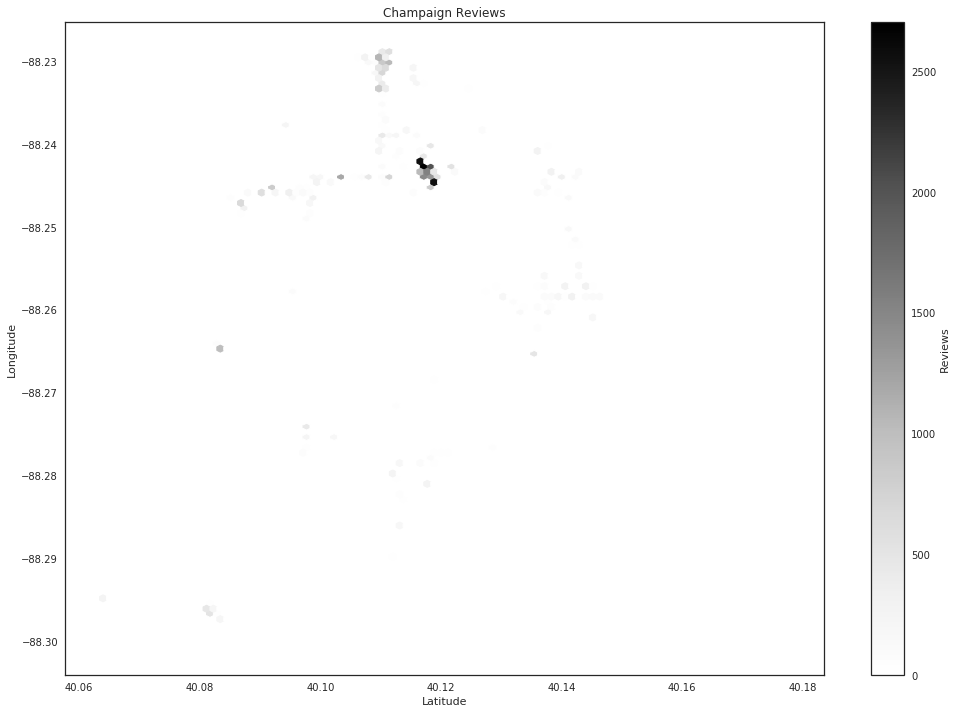

In [38]:
x = Unique_Reviews['latitude']
y = Unique_Reviews['longitude']
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(17,12))
hb = plt.hexbin(x,y)
plt.title('Champaign Reviews')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

Let's break down the figure above. The locations are identified by inputing the latitude and longitude coordinates on Google Maps. For this question, popularity is loosely defined as the number of reviews in a specific geographical location.

- The area on the right, where the most reviews are located, is Downtown Champaign.
- The second most popular area, up in the top of the figure, is Campustown. This area runs through most of Green Street between Wright Street and 4th Street.

With few exceptions, none of the top 3 categories had large concentrations of reviews in other areas.

Again, the figure above takes into account reviews from all categories over the length of time that the database covers.

From Question 2, Step 2, Method 2 we found that the top 3 most reviewed categories were Nightlife, Bars, and American Traditional.

Did the top 3 categories stay popular in the same area over the course of the last 3 years?

# Part 3 Breaking the Data Apart
## Step 1: Isolate Top 3 Categories

One way to ensure that the data that we use from now on contains on the necessary parts is to create a new DataFrame. We take only each category from the entire dataset and use them for individual analysis. As a result, we have DataFrames with less information.

In [44]:
Nightlife_Reviews = Unique_Reviews[Unique_Reviews['category']=='Nightlife']
Bars_Reviews = Unique_Reviews[Unique_Reviews['category']=='Bars']
American_Traditional_Reviews = Unique_Reviews[Unique_Reviews['category']=='American (Traditional)']
Nightlife_Reviews.sample(5)

,name,address,postal_code,latitude,longitude,overall_stars,review_count,category,individual_stars,date,text,useful,funny,cool,new latitude,new longitude
date,,,,,,,,,,,,,,,,
2017-05-14,Sun Singer Wine and Spirits,1115 W Windsor Rd,61821,40.0832,-88.2644,4,85,Nightlife,1,2017-05-14 00:00:00,After putting down $60 ahead of time for reser...,1,0,0,0.173077,0.504190
2016-09-04,V Picasso,122 N Neil St,61820,40.1172,-88.2432,4,91,Nightlife,5,2016-09-04 00:00:00,"Sat outside on a perfect evening, the waiter w...",0,0,0,0.470280,0.800279
2016-01-24,Old Chicago,1910 N Neil St,61820,40.1398,-88.2438,3,56,Nightlife,5,2016-01-24 00:00:00,"Love the pizza here, great beer selection, and...",0,0,1,0.667832,0.791899
2014-03-16,Guido's Bar & Grill,2 E Main St,61820,40.1179,-88.2433,3,97,Nightlife,2,2014-03-16 00:00:00,The food is fantastic -- if you're willing to ...,0,0,0,0.476399,0.798883
2011-12-09,Jupiter's Pizzeria and Billiards,39 E Main St,61820,40.1177,-88.2415,4,91,Nightlife,4,2011-12-09 00:00:00,Great pizza and friendly service. The place i...,0,0,0,0.474650,0.824022


## Step 2: Set Periods of Time
We repeat the process from Step 1 but this time we create "smaller" DataFrames that are bound by time in addition to category.

To set up our figures we split up the DataFrames by year, from 2 years ago to this year.

In [45]:
This_Years_Nightlife_Reviews = Nightlife_Reviews['2017-01-01':'2017-12-10']
Last_Years_Nightlife_Reviews = Nightlife_Reviews['2016-01-01':'2016-12-31']
Last_Last_Years_NightLife_Reviews = Nightlife_Reviews['2015-01-01':'2015-12-31']
This_Years_Bars_Reviews = Bars_Reviews['2017-01-01':'2017-12-10']
Last_Years_Bars_Reviews = Bars_Reviews['2016-01-01':'2016-12-31']
Last_Last_Years_Bars_Reviews = Bars_Reviews['2015-01-01':'2015-12-31']
This_Years_American_Traditional_Reviews = American_Traditional_Reviews['2017-01-01':'2017-12-10']
Last_Years_American_Traditional_Reviews = American_Traditional_Reviews['2016-01-01':'2016-12-31']
Last_Last_Years_American_Traditional_Reviews = American_Traditional_Reviews['2015-01-01':'2015-12-31']
This_Years_Nightlife_Reviews.sample(5)

,name,address,postal_code,latitude,longitude,overall_stars,review_count,category,individual_stars,date,text,useful,funny,cool,new latitude,new longitude
date,,,,,,,,,,,,,,,,
2017-07-18,Guido's Bar & Grill,2 E Main St,61820,40.1179,-88.2433,3,97,Nightlife,3,2017-07-18 00:00:00,Guido's Nachos are awesome!!! We only go when ...,0,0,0,0.476399,0.798883
2017-01-22,Watson's Shack & Rail,211 N Neil St,61820,40.1177,-88.2439,4,113,Nightlife,5,2017-01-22 00:00:00,"Everytime I've been to Watson's, I've enjoyed ...",1,0,1,0.474650,0.790503
2017-02-04,Hamilton Walker's,201 N Neil St,61820,40.1175,-88.2439,3,87,Nightlife,4,2017-02-04 00:00:00,Went there for lunch and had the Filet with pe...,1,0,1,0.472902,0.790503
2017-05-10,Houlihan's,1900 S 1st St,61820,40.0939,-88.2378,3,80,Nightlife,1,2017-05-10 00:00:00,Carly our server was very good and why I could...,0,0,0,0.266608,0.875698
2017-04-13,Seven Saints,32 E Chester St,61820,40.1166,-88.2420,4,273,Nightlife,4,2017-04-13 00:00:00,"Good atmosphere , just a sandwich place. I gue...",0,0,0,0.465035,0.817039


# Part 4: Visually Represent Time and Popularity

## Step 1 Nightlife Category

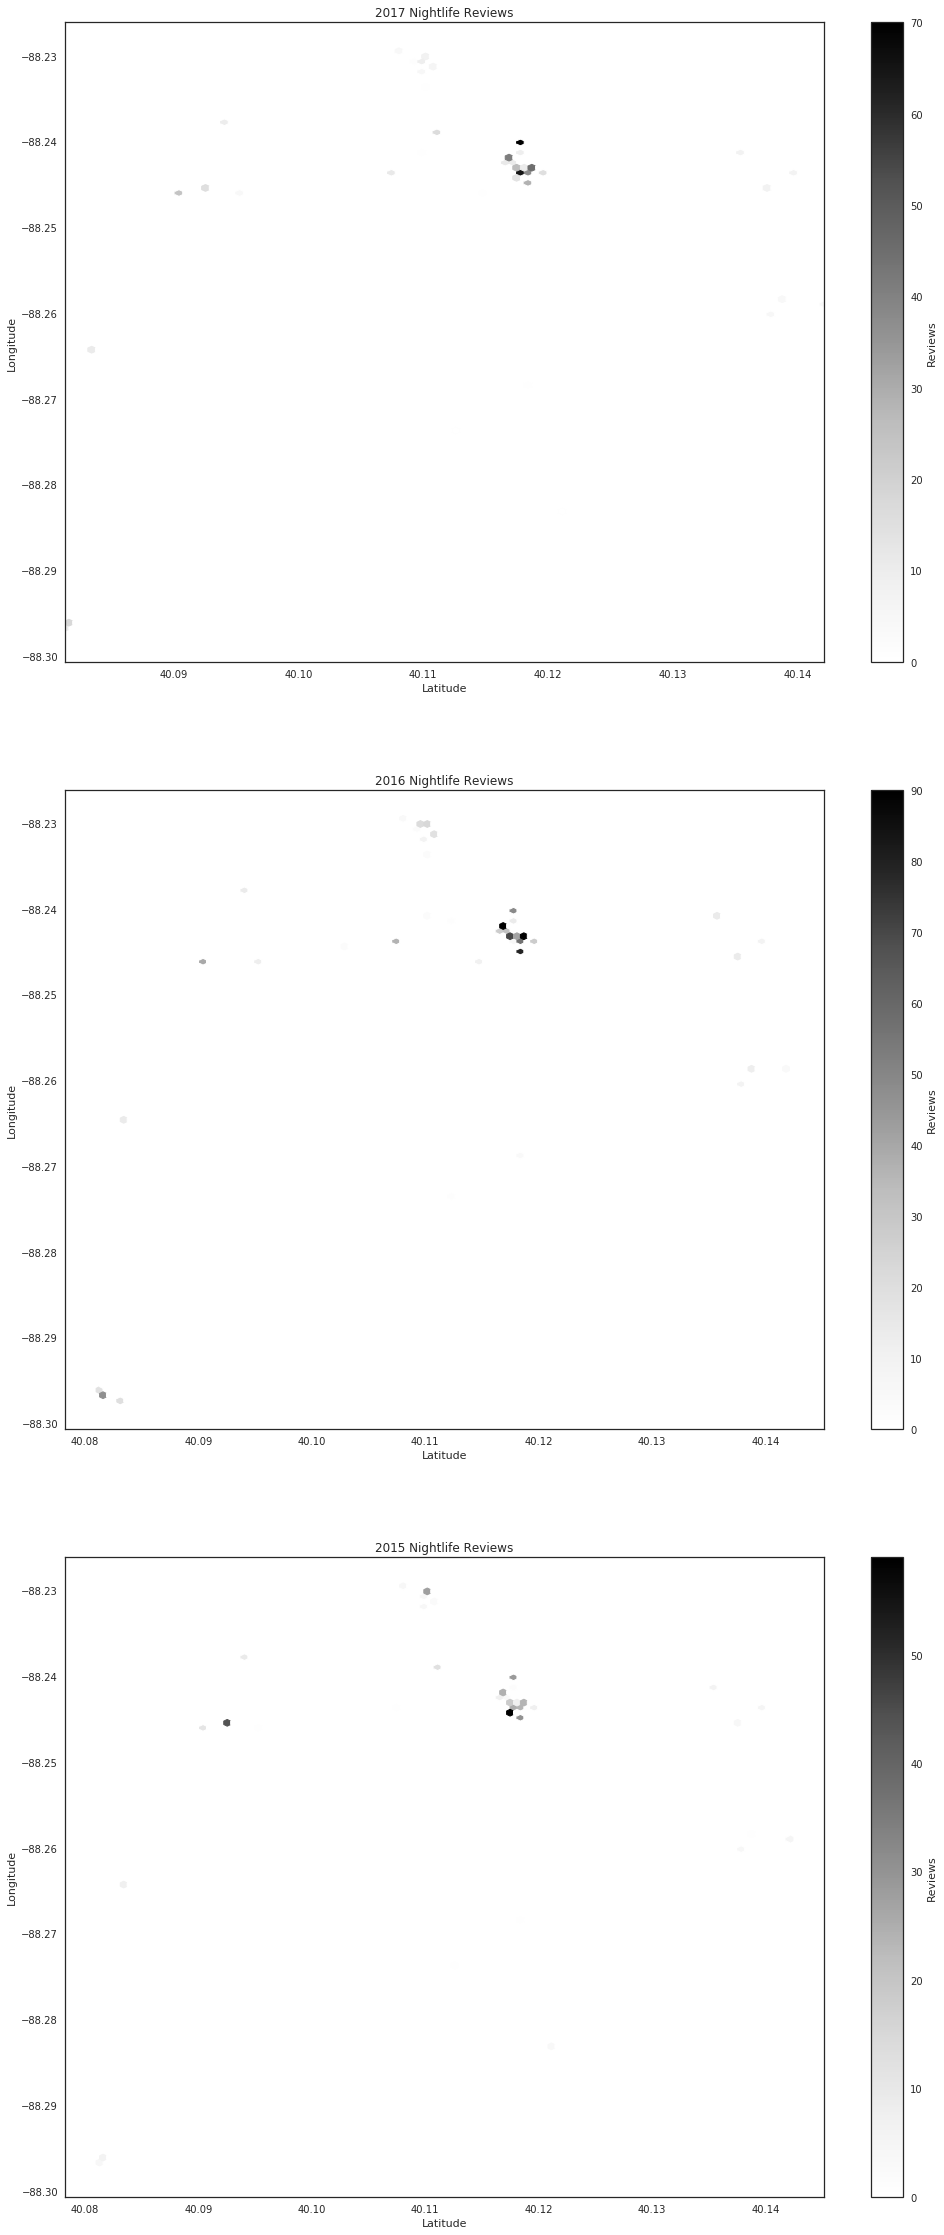

In [41]:
x = This_Years_Nightlife_Reviews['latitude']
y = This_Years_Nightlife_Reviews['longitude']
fig, axs = plt.subplots(nrows=3, sharey=True, figsize=(17,40))
fig.subplots_adjust(hspace = .2)
plt.hexbin(x,y)
ax = axs[0]
hb = ax.hexbin(x,y)
ax.set_title('2017 Nightlife Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Years_Nightlife_Reviews['latitude']
y = Last_Years_Nightlife_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[1]
ax.set_title('2016 Nightlife Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Last_Years_NightLife_Reviews['latitude']
y = Last_Last_Years_NightLife_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[2]
ax.set_title('2015 Nightlife Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

The figure above shows the concentration of reviews by latitude and longitude coordinates over the course of the last 2 years. The first figure lays out this year, the second last year, and so on.

We can see that once again Downtown Champaign has the most reviews for the Nightlife category. We see the biggest change from 2015 to 2016, when the amount of reviews shifted from the western spot to mostly Downtown Champaign.

## Step 2 Bars Category

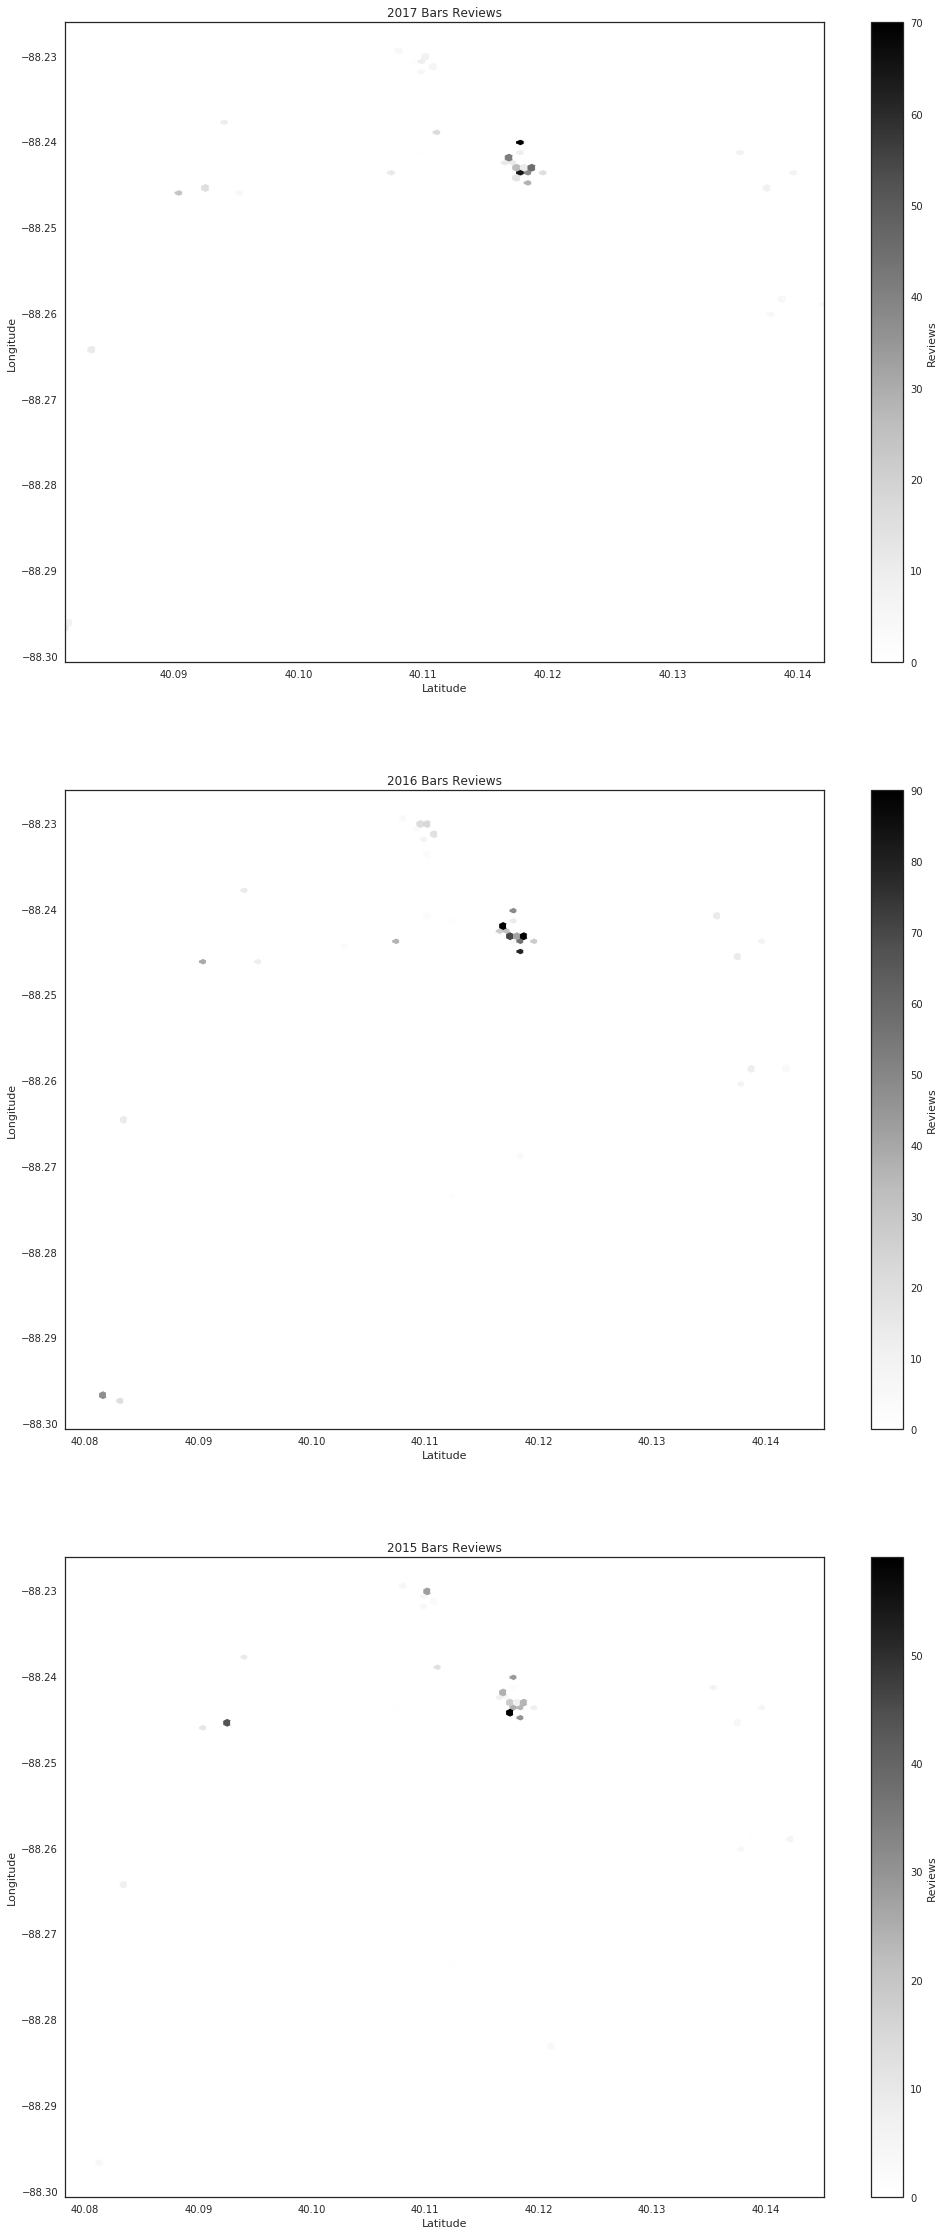

In [42]:
x = This_Years_Bars_Reviews['latitude']
y = This_Years_Bars_Reviews['longitude']
fig, axs = plt.subplots(nrows=3, sharey=True, figsize=(17,40))
fig.subplots_adjust(hspace = .2)
plt.hexbin(x,y)
ax = axs[0]
hb = ax.hexbin(x,y)
ax.set_title('2017 Bars Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Years_Bars_Reviews['latitude']
y = Last_Years_Bars_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[1]
ax.set_title('2016 Bars Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Last_Years_Bars_Reviews['latitude']
y = Last_Last_Years_Bars_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[2]
ax.set_title('2015 Bars Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

The Bars category follows the same narrative of the Nightlife category. From 2015 to 2016 again we saw the shift to Downtown Champaign, and that hasn't changed to this year. Downtown Champaign again has the best concentration of reviews in 2017.

## Step 3 American Traditional Category

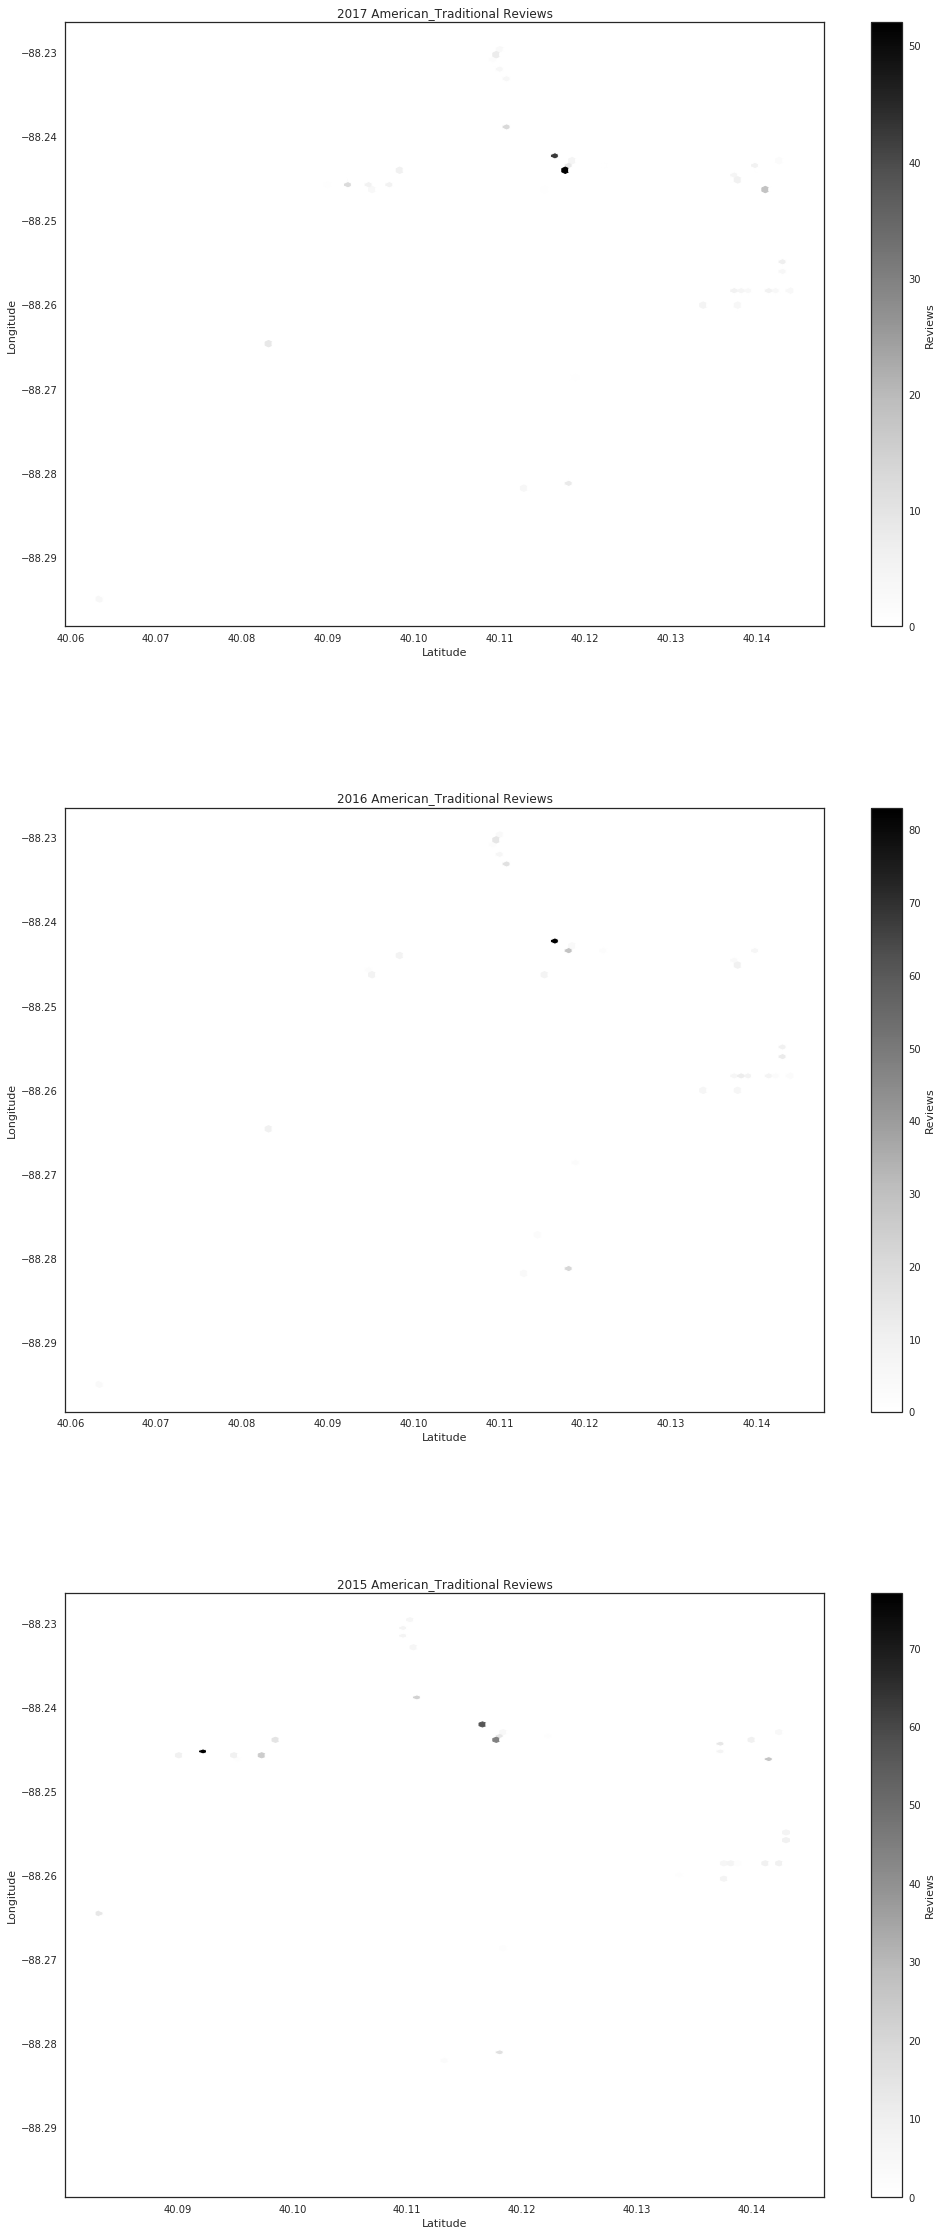

In [43]:
x = This_Years_American_Traditional_Reviews['latitude']
y = This_Years_American_Traditional_Reviews['longitude']
fig, axs = plt.subplots(nrows=3, sharey=True, figsize=(17,40))
fig.subplots_adjust(hspace = .3)
plt.hexbin(x,y)
ax = axs[0]
hb = ax.hexbin(x,y)
ax.set_title('2017 American_Traditional Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Years_American_Traditional_Reviews['latitude']
y = Last_Years_American_Traditional_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[1]
ax.set_title('2016 American_Traditional Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

x = Last_Last_Years_American_Traditional_Reviews['latitude']
y = Last_Last_Years_American_Traditional_Reviews['longitude']
hb = ax.hexbin(x,y)
ax = axs[2]
ax.set_title('2015 American_Traditional Reviews')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Reviews')

Surprisingly enough, the American Traditional category has the most reviews in the Downtown Champaign area. One difference we do see is that there is a slight increase in reviews in a small area to the east. 

# Part 5 Conclusion

For each of the top 3 categories we saw that the Downtown Champaign area remained the most reviewed geographical location over the last 2 years. While there have been instances where other areas received noticable amounts of reviews, these areas have dimished their footprint or disappeared entirely.

Therefore, to open a restaurant in one of the top 3 categories, the Downtown Champaign area is a good location to do this as the restaurant will have the best chance to withstanding the test of time.

# RECOMMENDATION

Our group recommends opening a restaurant under the “Nightlife” category in the Downtown Champaign area. We base this recommendation on the following arguments:
- At 3,458 reviews in Champaign, the “Nightlife” category has the most reviews, followed closely by the “Bars” category. While this may not be necessarily the case, since more people are both eating at and reviewing these kinds of restaurants it may follow that more people will visit them. Therefore, the most reviewed category on Yelp has a better chance of getting customers in the door of restaurants within that category.
- Not only is “Nightlife” the most reviewed category, but that distinction hasn’t changed over the last few years. “Nightlife” shows a consistent increase in the rate of reviews.
- The Downtown Champaign area accumulated the most reviews out of all of Champaign. This may mean that it is also experiencing the most foot traffic and attracts the most interest. More specifically, the most popular area is around Hill St. and University Ave.
- Choosing this location is a safer alternative, as the last few years show that while other locations’ reviews come and go, Downtown Champaign always has the most.
